# Object detection

## Jeremy Howard

###  Deep Learning Part 2 2018

[Cutting edge deep learning for coders (2018) - wiki](https://forums.fast.ai/t/about-the-part-2-alumni-2018-category/13050)

[Cutting edge deep learning for coders (2018) - vidéos](https://www.youtube.com/watch?v=Z0ssNAbe81M&list=PLfYUBJiXbdtTttBGq-u2zeY1OTjs5e-Ia)

- 08 Object detection : http://course18.fast.ai/lessons/lesson8.html
- 09 Multi-object detection : http://course18.fast.ai/lessons/lesson9.html

# Single object detection

Finding the localized area in which an object presides from two points, the bottom left and top right

![](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/06/maxresdefault.jpg)

In [1]:
from fastai2.vision.all import *

Fix fastai2 0.0.17 bug :
- bb_pad is added by BBoxBlock in the before_batch callback of the Dataloader
- learner.predict() creates a Dataloader with_labels=False
- in this context, bb_pad receives only (x,) and not (x,bbox,label) as expected

=> ERROR

Solution : replace fastai2 bb_pad by a fixed version of bb_pad

In [2]:
def fix_bb_pad(samples, pad_idx=0):
    if len(samples)==0 or len(samples[0])<3:
        return samples
    else:
        return bb_pad(samples, pad_idx)

In [3]:
BBoxBlock.dls_kwargs['before_batch'] = fix_bb_pad

## The Data

Before we begin training, let's focus on how to build the `DataLoader`. We'll want to use the `Pascal_VOC` dataset today

In [4]:
path = untar_data(URLs.PASCAL_2007)

Now how do we get our labels? `fastai2` has a `get_annotations` function that we can use to grab the image and their bounding box. The one-line documentation states:
"Open a COCO style json in `fname` and returns the list of filenames (with mabye `prefix`) and labelled bounding boxes."

In [5]:
path.ls()

(#8) [Path('/storage/data/pascal_2007/valid.json'),Path('/storage/data/pascal_2007/test.csv'),Path('/storage/data/pascal_2007/train.json'),Path('/storage/data/pascal_2007/segmentation'),Path('/storage/data/pascal_2007/test'),Path('/storage/data/pascal_2007/train'),Path('/storage/data/pascal_2007/test.json'),Path('/storage/data/pascal_2007/train.csv')]

We'll want to read out of the `train.json`

In [6]:
img_names, bboxes_and_labels = get_annotations(path/'train.json')

In [7]:
len(img_names)

2501

In [8]:
img_names[1]

'000017.jpg'

In [9]:
bboxes_and_labels[1]

([[184, 61, 279, 199], [89, 77, 403, 336]], ['person', 'horse'])

Next, we want to be able to quickly look up a corresponding image to it's label. We'll use a dictionary

In [10]:
img_name_to_bboxes_and_labels = dict(zip(img_names, bboxes_and_labels))

Let's check the first two items

In [11]:
first = {k: img_name_to_bboxes_and_labels[k] for k in list(img_name_to_bboxes_and_labels)[:2]}; first

{'000012.jpg': ([[155, 96, 351, 270]], ['car']),
 '000017.jpg': ([[184, 61, 279, 199], [89, 77, 403, 336]],
  ['person', 'horse'])}

Great! Now let's build our `DataBlock`. We'll have two outputs, the bounding box itself and a label, with one input. For our `y`'s, we'll define some `getters`.

In [12]:
getters = [lambda o: path/'train'/o, lambda o: img_name_to_bboxes_and_labels[o][0], 
                                     lambda o: img_name_to_bboxes_and_labels[o][1] ]

Visualize one example :

In [13]:
def get_image_and_labels(idx):
    img_name = img_names[idx]
    img_path, bboxes, bboxlabels = getters[0](img_name), getters[1](img_name), getters[2](img_name)
    return Image.open(img_path), bboxes, bboxlabels

In [14]:
get_image_and_labels(1)

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x364 at 0x7FAB73BB8DD0>,
 [[184, 61, 279, 199], [89, 77, 403, 336]],
 ['person', 'horse'])

In [15]:
def show_image_labels(idx, ctx=None, display_shape=True):
    img, bboxes, bboxlabels = get_image_and_labels(idx)
    timg = TensorImage(image2tensor(img))
    tlabeledbboxes = LabeledBBox(TensorBBox(bboxes), bboxlabels)
    if display_shape:
        print(timg.shape)
    ctx = timg.show(figsize=(7,7), ctx=ctx)
    tlabeledbboxes.show(ctx=ctx);

torch.Size([3, 333, 500])


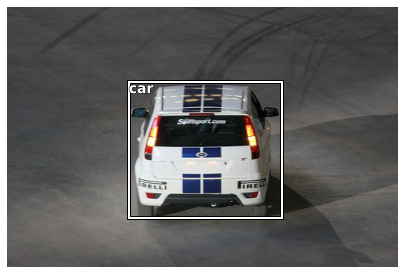

In [16]:
show_image_labels(0)

torch.Size([3, 364, 480])


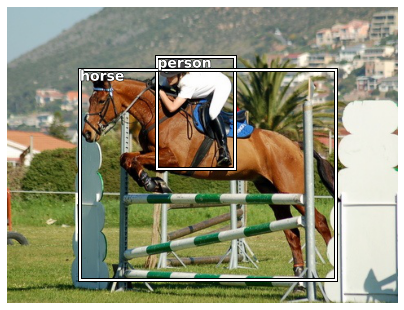

In [17]:
show_image_labels(1)

In [16]:
def show_batch(lines=3):
    fig, axes = plt.subplots(lines, 4, figsize=(12, 2*lines))
    for i,ax in enumerate(axes.flat):
        show_image_labels(i, ctx=ax, display_shape=False)
    plt.tight_layout()

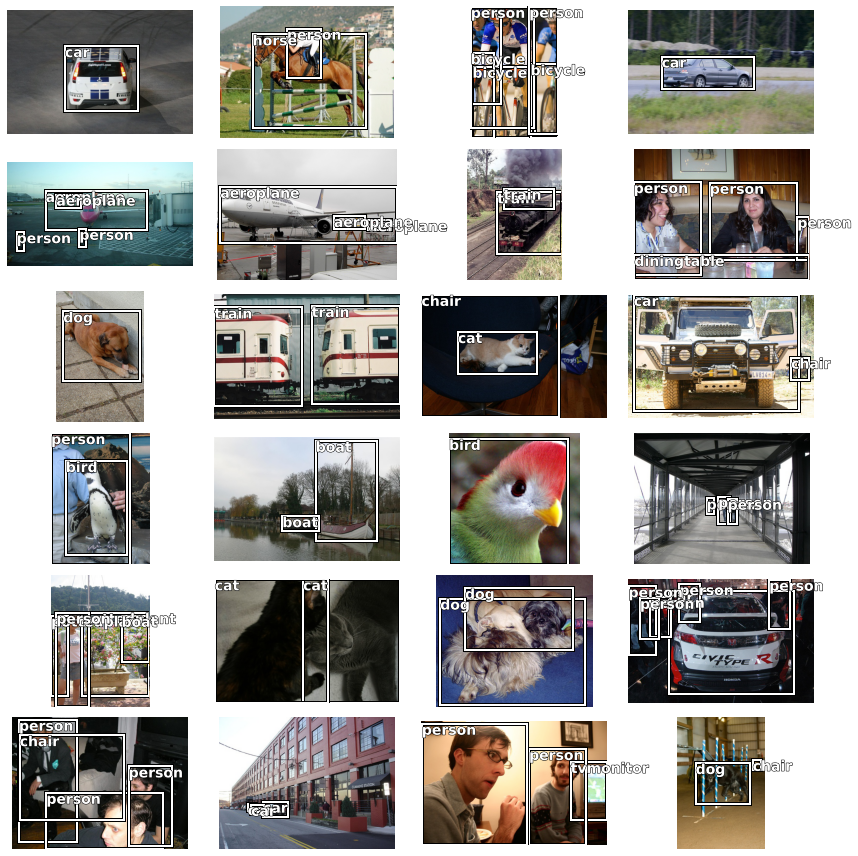

In [19]:
show_batch(6)

## Largest item classifier

### Find largest item

In [20]:
annot = bboxes_and_labels[1]
annot

([[184, 61, 279, 199], [89, 77, 403, 336]], ['person', 'horse'])

In [21]:
labeled_bboxes = list(zip(annot[0],annot[1]))
labeled_bboxes

[([184, 61, 279, 199], 'person'), ([89, 77, 403, 336], 'horse')]

In [22]:
labeled_bbox = labeled_bboxes[0]
bbox = tensor(labeled_bbox[0])
x1_y1 = bbox[:2]
x2_y2 = bbox[-2:]
width_height = x2_y2-x1_y1
surface = width_height.prod()
x1_y1 ,x2_y2, width_height, surface

(tensor([184,  61]), tensor([279, 199]), tensor([ 95, 138]), tensor(13110))

In [23]:
def get_box_surface(labeled_bbox):
    bbox = tensor(labeled_bbox[0])
    x1_y1 = bbox[:2]
    x2_y2 = bbox[-2:]
    width_height = x2_y2-x1_y1
    surface = width_height.prod()
    return surface

In [24]:
def get_largest_box(annot):
    labeled_bboxes = zip(annot[0],annot[1])
    labeled_bboxes = sorted(labeled_bboxes, key=get_box_surface, reverse=True)
    return labeled_bboxes[0]

In [25]:
labeled_bbox = get_largest_box(annot)
labeled_bbox

([89, 77, 403, 336], 'horse')

In [17]:
def show_largest_box(idx):
    show_image_labels(idx)
    labeled_bbox = get_largest_box(bboxes_and_labels[idx])
    print(labeled_bbox)

torch.Size([3, 364, 480])
([89, 77, 403, 336], 'horse')


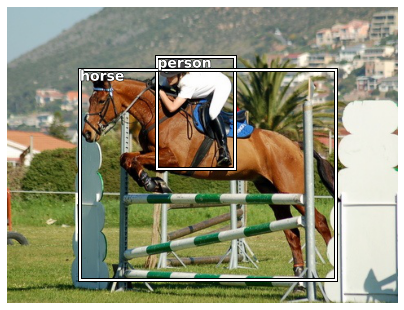

In [27]:
show_largest_box(1)

torch.Size([3, 333, 500])
([14, 0, 459, 312], 'car')


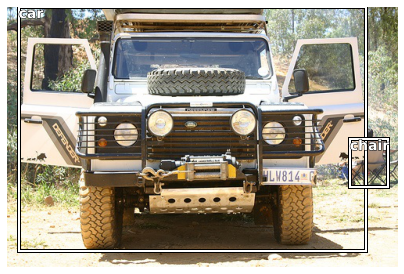

In [28]:
show_largest_box(11)

### Dataloaders

Why do we need a custom `get_images`? Because we want our **images** that came back to us, not the entire folder

In [18]:
def get_img_names(path): return img_names

In [19]:
def get_img_path(img_name): return path/'train'/img_name

In [20]:
def get_largest_box_label(img_name):
    annot = img_name_to_bboxes_and_labels[img_name]
    labeled_bbox = get_largest_box(annot)
    return labeled_bbox[1]

In [32]:
img_name = get_img_names(path)[1]
img_path = get_img_path(img_name)
img_label = get_largest_box_label(img_name)
img_path, img_label

(Path('/storage/data/pascal_2007/train/000017.jpg'), 'horse')

For our transforms, we'll use some of the ones we defined earlier

In [21]:
item_tfms = [Resize(224)]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [34]:
classifierdb = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_img_names, 
                 get_x = get_img_path,
                 get_y = get_largest_box_label,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 splitter=RandomSplitter())

In [ ]:
classifierdls = classifierdb.dataloaders(path)

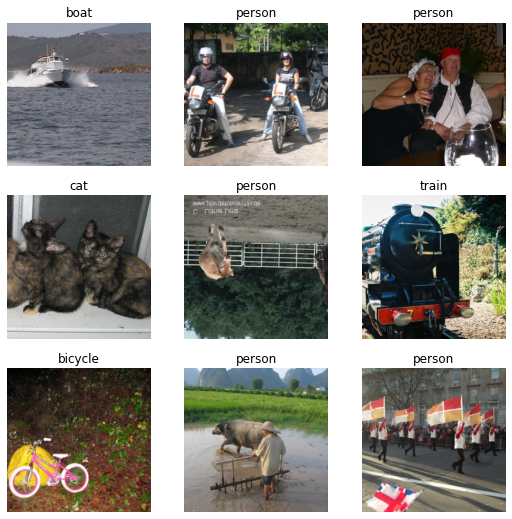

In [36]:
classifierdls.show_batch()

### Classifier

In [37]:
learn1 = cnn_learner(classifierdls, resnet34, metrics=error_rate)

In [38]:
learn1.fine_tune(10)

In [39]:
learn1.save("1-classifier")

In [40]:
learn1.load("1-classifier")

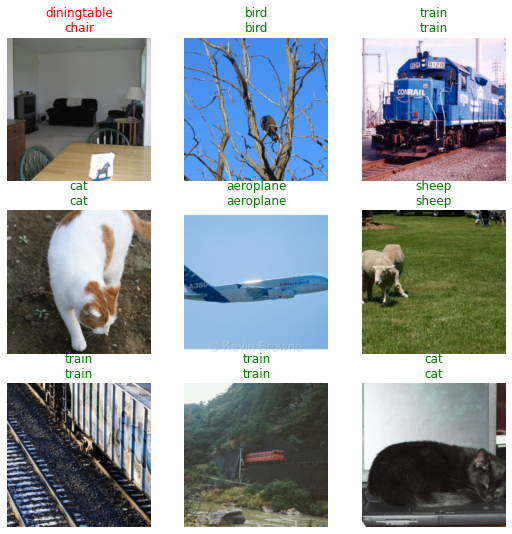

In [41]:
learn1.show_results()

In [42]:
learn1.model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [43]:
learn1.model[0].summary(classifierdls.one_batch()[0])

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
_________________________________________________

In [44]:
learn1.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=20, bias=False)
)

## Predict largest bounding box with label

### Find largest bounding box with label

IMPORTANT :
- BBoxBlock and BBoxLblBlock must always be used together (BBoxBlock alone doesn't work => use PointBlock)
- BBoxBlock => y1 must be a list of lists of 4 integers
- BBoxLblBlock => y2 must be a list of classes 

NB : the label prediction is of type MultiCategory (to be able to predict background).

In [45]:
def get_largest_box_coords(img_name):
    annot = img_name_to_bboxes_and_labels[img_name]
    labeled_bbox = get_largest_box(annot)
    return [labeled_bbox[0]]

In [46]:
def get_largest_box_labels(img_name):
    return [get_largest_box_label(img_name)]

In [47]:
x = get_img_path(img_name)
y1 = get_largest_box_coords(img_name)
y2 = get_largest_box_labels(img_name)
x, y1, y2

(Path('/storage/data/pascal_2007/train/000017.jpg'),
 [[89, 77, 403, 336]],
 ['horse'])

### Dataloaders

In [48]:
bboxdb = DataBlock(blocks=(ImageBlock, BBoxBlock,BBoxLblBlock),
                 get_items=get_img_names, 
                 get_x = get_img_path, n_inp=1,
                 get_y = [get_largest_box_coords,get_largest_box_labels],
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 splitter=RandomSplitter())

In [49]:
bboxdb.summary(path)

Setting-up type transforms pipelines
Found 2501 items
2 datasets of sizes 2001,500
Setting up Pipeline: get_img_path -> PILBase.create
Setting up Pipeline: get_largest_box_coords -> TensorBBox.create
Setting up Pipeline: get_largest_box_labels -> MultiCategorize

Building one sample
  Pipeline: get_img_path -> PILBase.create
    starting from
      001950.jpg
    applying get_img_path gives
      /storage/data/pascal_2007/train/001950.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: get_largest_box_coords -> TensorBBox.create
    starting from
      001950.jpg
    applying get_largest_box_coords gives
      [[1, 357, 100, 375]]
    applying TensorBBox.create gives
      TensorBBox of size 1x4
  Pipeline: get_largest_box_labels -> MultiCategorize
    starting from
      001950.jpg
    applying get_largest_box_labels gives
      [car]
    applying MultiCategorize gives
      TensorMultiCategory([7])

Final sample: (PILImage mode=RGB size=500x375, Ten

In [50]:
bboxdls = bboxdb.dataloaders(path)

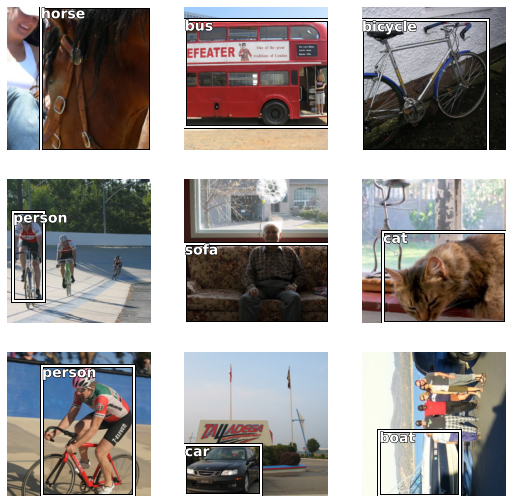

In [54]:
bboxdls.show_batch()

### Dataloaders, Datasets, Pipeline, Transform, show()

In [55]:
type(bboxdls.dataset.items),len(bboxdls.dataset.items),bboxdls.dataset.items[:10]

(list,
 2001,
 ['004584.jpg',
  '002881.jpg',
  '008840.jpg',
  '002166.jpg',
  '008814.jpg',
  '000256.jpg',
  '006131.jpg',
  '001989.jpg',
  '003244.jpg',
  '004296.jpg'])

In [56]:
type(bboxdls.dataset.tfms[0]),len(bboxdls.dataset.tfms)

(fastcore.transform.Pipeline, 3)

In [57]:
bboxdls.dataset.tfms[0],bboxdls.dataset.tfms[1],bboxdls.dataset.tfms[2]

(Pipeline: get_img_path -> PILBase.create,
 Pipeline: get_largest_box_coords -> TensorBBox.create,
 Pipeline: get_largest_box_labels -> MultiCategorize)

In [58]:
type(bboxdls.dataset.tfms[0][1]),bboxdls.dataset.tfms[0][1]

(fastcore.transform.Transform,
 PILBase.create: (bytes,object) -> create
 (ndarray,object) -> create
 (Tensor,object) -> create
 (str,object) -> create
 (Path,object) -> create )

In [59]:
#MultiCategorize??

In [60]:
type(bboxdls.dataset.splits),len(bboxdls.dataset.splits)

(fastcore.foundation.L, 2)

In [61]:
type(bboxdls.dataset.splits[0]),len(bboxdls.dataset.splits[0]),len(bboxdls.dataset.splits[1]),bboxdls.dataset.splits[0][:10]

(list, 2001, 500, [1155, 717, 2201, 529, 2197, 59, 1556, 488, 805, 1089])

In [62]:
image1, bbox1, label1 = bboxdls.dataset[1]
image1, bbox1, label1

(PILImage mode=RGB size=500x500,
 TensorBBox([[ 84.,  42., 323., 470.]]),
 TensorMultiCategory([15]))

TensorBBox doc :

Bounding boxes are expected to come as tuple with an array/tensor of shape (n,4) or as a list of lists with four elements and a list of corresponding labels. Unless you change the defaults in PointScaler (see later on), coordinates for each bounding box should go from 0 to width/height, with the following convention: x1, y1, x2, y2 where (x1,y1) is your top-left corner and (x2,y2) is your bottom-right corner.

In [63]:
bboxdls.after_item

Pipeline: BBoxLabeler -> PointScaler -> Resize -> ToTensor

In [64]:
bboxdls.after_item[0]

BBoxLabeler:  (TensorBBox,object) -> decodes
(TensorMultiCategory,object) -> decodes

In [65]:
#BBoxLabeler??

In [66]:
bboxdls.after_item[1]

PointScaler: (TensorBBox,object) -> encodes
(TensorImageBase,object) -> encodes
(PILBase,object) -> encodes
(TensorPoint,object) -> encodes (TensorBBox,object) -> decodes
(TensorImageBase,object) -> decodes
(PILBase,object) -> decodes
(TensorPoint,object) -> decodes

In [67]:
bboxdls.after_item[2]

Resize: (TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(Image,object) -> encodes 

In [68]:
bboxdls.after_item[3]

ToTensor: (PILMask,object) -> encodes
(PILBase,object) -> encodes 

In [69]:
image2, bbox2, label2 = bboxdls.after_item((image1, bbox1, label1))
(type(image2), image2.shape), bbox2, label2

((fastai2.torch_core.TensorImage, torch.Size([3, 224, 224])),
 TensorBBox([[-0.6640, -0.8320,  0.2920,  0.8800]]),
 TensorMultiCategory([15]))

In [70]:
image1d, bbox1d, label1d = bboxdls.after_item.decode((image2, bbox2, label2))
(type(image1d), image1d.shape), bbox1d, label1d

((fastai2.torch_core.TensorImage, torch.Size([3, 224, 224])),
 TensorBBox([[ 37.6320,  18.8160, 144.7040, 210.5600]]),
 (#2) [TensorBBox([[ 37.6320,  18.8160, 144.7040, 210.5600]]),['person']])

In [71]:
image1, bbox1, label1

(PILImage mode=RGB size=500x500,
 TensorBBox([[ 84.,  42., 323., 470.]]),
 TensorMultiCategory([15]))

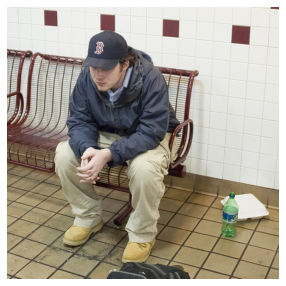

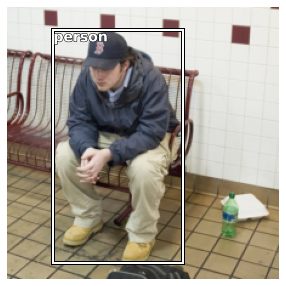

In [72]:
image1.show(); ctx=image1d.show(); label1d.show(ctx)

In [73]:
bboxdls.before_batch

Pipeline: fix_bb_pad

In [74]:
bboxdls.after_batch

Pipeline: IntToFloatTensor -> AffineCoordTfm -> Normalize

How to test a Dataloader on a specific data item :

In [75]:
img_name

'000017.jpg'

In [76]:
x, y1, y2 = bboxdls.test_dl(img_name, with_labels=True).one_batch()
(type(x),x.shape), y1, y2

((fastai2.torch_core.TensorImage, torch.Size([1, 3, 224, 224])),
 TensorBBox([[[-0.8297, -0.5769,  0.8956,  0.8462]]], device='cuda:0'),
 TensorMultiCategory([[13]], device='cuda:0'))

### Model

https://dev.fast.ai/vision.learner

In [77]:
#doc(cnn_learner)

In [78]:
#cnn_learner??

In [79]:
#doc(create_cnn_model)

In [80]:
#create_cnn_model??

IMPORTANT : for fastai2 "show" methods to work, the architecture must return the same number of values as the ys in the dataloader.

=> we need create a custom head which will return a tuple two tensors : (bounding boxes, boxes labels)

IMPORTANT : in the transforms pipeline, PointScaler converts all boxes coordinates between -1 / 1 (top left, bottom right)

=> y_range=[-1,1]

In [81]:
customhead = create_head(nf=1024, n_out=4, y_range=[-1,1])
customhead

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
  (9): SigmoidRange(low=-1, high=1)
)

In [82]:
# -- Failed attempt -> doesn't work for bboxes --
class FailedBBoxLblHead(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.bboxhead = create_head(nf=1024, n_out=4, y_range=[-1,1])
        self.labelhead = create_head(nf=1024, n_out=n_classes)
    
    def forward(self, x):
        return (self.bboxhead(x),self.labelhead(x))

In [83]:
class SingleBBoxLblHead(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.bboxlblhead = create_head(nf=1024, n_out=4 + n_classes)
        self.bboxrange = SigmoidRange(-1,1)
    
    def forward(self, x):
        activations = self.bboxlblhead(x)
        bbox_activations = self.bboxrange(activations[:,:4])
        label_activations = activations[:,4:]
        return (bbox_activations,label_activations)

In [84]:
bboxmodel = create_cnn_model(resnet34, n_out=None, pretrained=True, custom_head=SingleBBoxLblHead(20))

In [85]:
bboxmodel[1]

SingleBBoxLblHead(
  (bboxlblhead): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten(full=False)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=False)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=24, bias=False)
  )
  (bboxrange): SigmoidRange(low=-1, high=1)
)

In [87]:
bboxmodel.to(bboxdls.device)
bboxmodel.summary(bboxdls.one_batch()[0])

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
_________________________________________________

### Loss function

In [88]:
learn2 = Learner(bboxdls, bboxmodel)

In [89]:
type(learn2.loss_func)

fastai2.layers.BCEWithLogitsLossFlat

**Targets**

In [90]:
x, bbox_target, label_target = bboxdls.one_batch()
print(type(bbox_target), type(label_target))
bbox_target.shape, label_target.shape

<class 'fastai2.vision.core.TensorBBox'> <class 'fastai2.torch_core.TensorMultiCategory'>


(torch.Size([64, 1, 4]), torch.Size([64, 1]))

**Activations**

In [91]:
bbox_activations, label_activations = learn2.model(x)
bbox_activations.shape, label_activations.shape

(torch.Size([64, 4]), torch.Size([64, 20]))

**Bounding boxes loss**

In [92]:
bbox_activations.shape,bbox_target.shape

(torch.Size([64, 4]), torch.Size([64, 1, 4]))

In [93]:
bbox_target.squeeze(1).shape

torch.Size([64, 4])

In [94]:
list(zip(bbox_activations[:3].data,bbox_target.squeeze(1)[:3].data))

[(tensor([ 1.0000,  0.8589, -0.7035, -0.9671], device='cuda:0'),
  tensor([-1.0000, -0.5495,  1.0000,  0.8679], device='cuda:0')),
 (tensor([ 0.9978,  0.5107, -0.0849, -0.9587], device='cuda:0'),
  tensor([-0.5000, -1.0000,  0.7254,  1.0000], device='cuda:0')),
 (tensor([ 1.0000,  0.9132, -0.9886, -1.0000], device='cuda:0'),
  tensor([-0.5556, -1.0000,  0.6396,  1.0000], device='cuda:0'))]

In [95]:
bbox_loss = F.l1_loss(bbox_activations[:3], bbox_target.squeeze(1)[:3], reduction='none')
bbox_loss

tensor([[2.0000, 1.4084, 1.7035, 1.8350],
        [1.4978, 1.5107, 0.8102, 1.9587],
        [1.5555, 1.9132, 1.6282, 2.0000]], device='cuda:0',
       grad_fn=<L1LossBackward>)

In [96]:
bbox_loss.mean(1)

tensor([1.7367, 1.4444, 1.7742], device='cuda:0', grad_fn=<MeanBackward1>)

**Labels loss**

In [97]:
label_activations.shape,label_target.shape

(torch.Size([64, 20]), torch.Size([64, 1]))

**Encode labels targets**

In [98]:
tmp_label_target = label_target.squeeze()

In [99]:
tmp_label_target[:5]

tensor([ 6, 19,  7, 15, 15], device='cuda:0')

In [100]:
tmp_label_target.min(),tmp_label_target.max()

(TensorMultiCategory(1, device='cuda:0'),
 TensorMultiCategory(19, device='cuda:0'))

In [101]:
bboxdls.vocab

(#21) ['#na#','aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair'...]

In [102]:
tmp_label_target = tmp_label_target-1

In [103]:
tmp_label_target[:5]

tensor([ 5, 18,  6, 14, 14], device='cuda:0')

In [104]:
encoded_label_target = tmp_label_target.new_zeros(len(tmp_label_target), 20).float()
encoded_label_target.shape

torch.Size([64, 20])

In [105]:
batch_idxs = LongTensor(list(range(len(encoded_label_target))))
batch_idxs[:15]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [106]:
mask = tmp_label_target >= 0
mask.shape

torch.Size([64])

In [107]:
list(zip(batch_idxs[mask],tmp_label_target[mask]))[:5]

[(tensor(0), tensor(5, device='cuda:0')),
 (tensor(1), tensor(18, device='cuda:0')),
 (tensor(2), tensor(6, device='cuda:0')),
 (tensor(3), tensor(14, device='cuda:0')),
 (tensor(4), tensor(14, device='cuda:0'))]

In [108]:
encoded_label_target[batch_idxs[mask],tmp_label_target[mask]].shape

torch.Size([64])

In [109]:
encoded_label_target[batch_idxs[mask],tmp_label_target[mask]] = 1

In [110]:
encoded_label_target[:5,13:]

tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')

In [111]:
def one_hot_encode_class(label_target, n_classes):
    tmp_label_target = label_target.squeeze()
    tmp_label_target = tmp_label_target-1
    encoded_label_target = tmp_label_target.new_zeros(len(tmp_label_target), n_classes).float()
    batch_idxs = LongTensor(list(range(len(encoded_label_target))))
    mask = tmp_label_target >= 0
    encoded_label_target[batch_idxs[mask],tmp_label_target[mask]] = 1
    return encoded_label_target

In [112]:
encoded_label_target = one_hot_encode_class(label_target,20)
encoded_label_target[:5,13:]

tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')

In [113]:
label_activations.shape, encoded_label_target.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

**Decode labels activations**

In [114]:
decoded_label_activations = torch.argmax(label_activations,1)+1
decoded_label_activations[:10],label_target[:10]

(tensor([ 7, 19, 10, 19, 19,  7, 17, 17,  5, 19], device='cuda:0'),
 tensor([[ 6],
         [19],
         [ 7],
         [15],
         [15],
         [15],
         [ 6],
         [15],
         [ 7],
         [15]], device='cuda:0'))

In [115]:
decoded_label_activations.shape, label_target.shape

(torch.Size([64]), torch.Size([64, 1]))

In [116]:
decoded_label_activations.unsqueeze(1).shape, label_target.shape

(torch.Size([64, 1]), torch.Size([64, 1]))

Labels loss

In [117]:
label_loss = F.binary_cross_entropy_with_logits(label_activations, encoded_label_target)
label_loss

tensor(1.9992, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

**Combined bounding boxes and labels loss**

IMPORTANT : for learn.get_preds, learn.predict and lean.show_results to work
- define a self.reduction property, used to compute the forward method, and supporting reduction='none'
- define a activation method on the loss module (optional sigmoid or softmax on the activations) 
  => get_preds()
- define a decodes method on the loss module (apply on activations, result = align predictions with target, must be the SAME EXACT SHAPE, ex: argmax)
  => get_preds(with_decoded=True) / predict

In [118]:
class BBoxLblLoss(Module):    
    def __init__(self):
        self.reduction = 'mean'
        self.l1_loss = F.l1_loss
        self.binary_cross_entropy = F.binary_cross_entropy_with_logits

    def forward(self, activations, bbox_target, label_target):        
        bbox_activations, label_activations = activations
        encoded_label_target = one_hot_encode_class(label_target, 20)
        bbox_loss = self.l1_loss(bbox_activations, bbox_target.squeeze(1), reduction=self.reduction)            
        label_loss = self.binary_cross_entropy(label_activations, encoded_label_target, reduction=self.reduction)        
        if self.reduction=='none':
            bbox_loss = bbox_loss.mean(1)
            label_loss = label_loss.mean(1)
        return bbox_loss + label_loss
    
    def activation(self, activations):               
        bbox_activations, label_activations = activations
        return bbox_activations, torch.sigmoid(label_activations)
    
    def decodes(self, activations):
        bbox_activations, label_activations = activations
        return bbox_activations, (torch.argmax(label_activations,1)+1).unsqueeze(1)
    
bboxlbl_loss = BBoxLblLoss()

**Metrics**

In [119]:
def bbox_l1(activations, bbox_target, label_target):
    bbox_activations = activations[0]
    return F.l1_loss(bbox_activations, bbox_target.squeeze(1)).data

def label_bce(activations, bbox_target, label_target):
    label_activations = activations[1]
    encoded_label_target = one_hot_encode_class(label_target, 20)
    return 20*F.binary_cross_entropy_with_logits(label_activations, encoded_label_target)

def label_acc(activations, bbox_target, label_target):
    label_activations = activations[1]
    label_target = label_target-1
    return accuracy(label_activations,label_target)

In [120]:
x, bbox_target, label_target = bboxdls.train.one_batch()
activations = learn2.model(x)
loss = bboxlbl_loss(activations, bbox_target, label_target)
metric1 = bbox_l1(activations, bbox_target, label_target)
metric2 = label_bce(activations, bbox_target, label_target)
metric3 = label_acc(activations, bbox_target, label_target)
print(loss.item(),metric1.item(),metric2.item(),metric3.item())

3.3827710151672363 1.3496733903884888 40.661956787109375 0.03125


In [121]:
bboxlbl_loss.reduction='none'
bboxlbl_loss(activations, bbox_target, label_target)

tensor([3.6424, 2.3103, 3.9569, 4.4674, 3.6259, 4.2095, 2.7284, 2.8822, 3.5579,
        3.9232, 3.1041, 3.1928, 3.8087, 3.0623, 2.1293, 3.0369, 3.1275, 3.8506,
        3.6858, 3.3748, 3.0498, 3.4984, 4.6134, 3.0656, 4.0711, 3.6955, 3.7394,
        4.0984, 2.5654, 3.0630, 3.1954, 3.0303, 3.3791, 2.7129, 4.4351, 3.7117,
        4.4253, 4.1074, 3.0656, 3.0973, 4.2064, 4.2199, 3.4984, 2.6940, 2.9431,
        3.1172, 2.9738, 3.0440, 3.0030, 2.7605, 3.3906, 2.9250, 3.2357, 2.8544,
        3.3671, 3.3339, 3.5228, 2.9272, 2.8263, 4.2642, 3.3500, 2.9144, 3.0964,
        3.7317], device='cuda:0', grad_fn=<AddBackward0>)

In [122]:
bboxlbl_loss.reduction='mean'
bboxlbl_loss(activations, bbox_target, label_target)

tensor(3.3828, device='cuda:0', grad_fn=<AddBackward0>)

### Training - Transfer learning

IMPORTANT : when cnn_learner() is not used to create a Learner, two things need to be done manually for transfer learning
- define a splitter to select the trainable params
- freeze the parameters of the body

In [123]:
resnet_splitter = model_meta[resnet34]['split']
resnet_splitter

<function fastai2.vision.learner._resnet_split(m)>

https://github.com/fastai/fastai2/blob/44c9a5921999a350e70dacdd068bda8d4973e5ba/nbs/21_vision.learner.ipynb

```python
def  _resnet_split(m): return L(m[0][:6], m[0][6:], m[1:]).map(params)
```

In [125]:
learn2 = Learner(bboxdls, 
                 bboxmodel, splitter=resnet_splitter,
                 loss_func=bboxlbl_loss, metrics=[bbox_l1,label_bce,label_acc])

In [126]:
learn2.freeze()

In [127]:
learn2.model.summary(x)

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
_________________________________________________

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.03981071710586548)

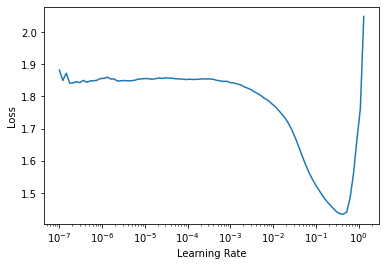

In [128]:
learn2.lr_find()

In [129]:
learn2.fit_one_cycle(10, 0.04)

In [130]:
learn2.unfreeze()

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=3.311311274956097e-06)

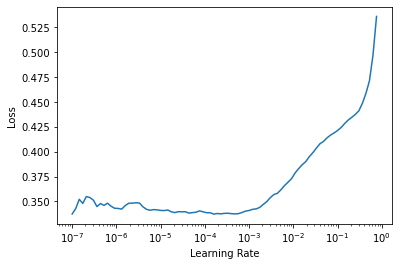

In [131]:
learn2.lr_find()

In [132]:
learn2.fit_one_cycle(10, slice(1e-6,1e-4))

In [133]:
learn2.save("2_singlebbox")

In [134]:
(learn2.path / learn2.model_dir).ls()

(#3) [Path('models/1-classifier.pth'),Path('models/2_singlebbox.pth'),Path('models/nn.pth')]

### Inference

In [135]:
learn2.load("2_singlebbox")

get_preds()

In [136]:
inputs, preds, targs, decoded, losses = learn2.get_preds(dl=bboxdls.valid, with_input=True, with_loss=True, with_decoded=True, act=None)
decoded[1][:3],targs[1][:3]

(tensor([[ 6],
         [ 7],
         [19]]),
 tensor([[ 6],
         [ 7],
         [19]]))

predict()

In [137]:
learn2.predict(img_names[1])

((TensorBBox([[ 35.4984,  39.2942, 208.6080, 195.1279]]),
  (#2) [TensorBBox([[ 35.4984,  39.2942, 208.6080, 195.1279]]),['horse']]),
 tensor([[-0.6831, -0.6492,  0.8626,  0.7422]]),
 tensor([[-0.6831, -0.6492,  0.8626,  0.7422]]))

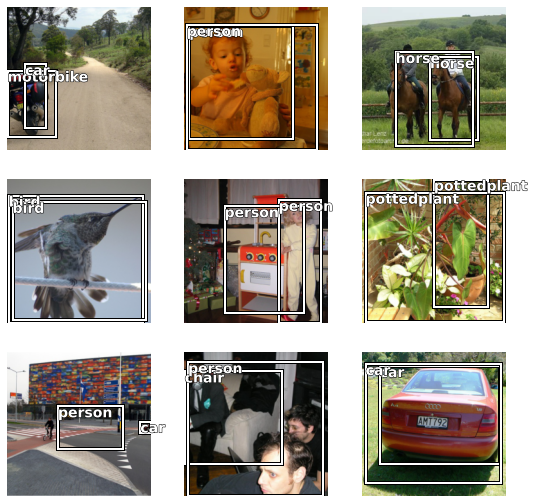

In [138]:
learn2.show_results()

**Interpret**

In [139]:
interp = Interpretation.from_learner(learn2)

In [140]:
top_losses, top_losses_idxs = interp.top_losses(12)
top_losses, top_losses_idxs

(tensor([1.2656, 1.2515, 1.2371, 0.9768, 0.9722, 0.9609, 0.9496, 0.9280, 0.9209,
         0.8847, 0.8323, 0.8226]),
 tensor([424, 321,  48, 405, 255, 411, 300, 486, 384, 180, 451, 285]))

IMPORTANT : Interpretation.plot_top_losses
- doesn't support preds with more than one output (y)
- is only implemented for three cases : simple image & text classification
  - plot_top_losses(x: TensorImage, y:TensorCategory,
  - plot_top_losses(x: TensorImage, y:TensorMultiCategory,
  - plot_top_losses(x: TensorText, y:TensorCategory,

In [141]:
#interp.plot_top_losses(12)

In [142]:
def plot_top_losses(interp, k, largest=True, **kwargs):
    losses,idx = interp.top_losses(k, largest)
    if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
    if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
    else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
    b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
    x,y,its = interp.dl._pre_show_batch(b, max_n=k)
    b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
    x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
    res = (x,x1,None,None) if its is None else (x, y, its, outs.itemgot(slice(interp.dl.n_inp,None)))
    #--> ONLY CHANGE BELOW <--
    show_results(*res, ctxs=None, max_n=k, **kwargs)

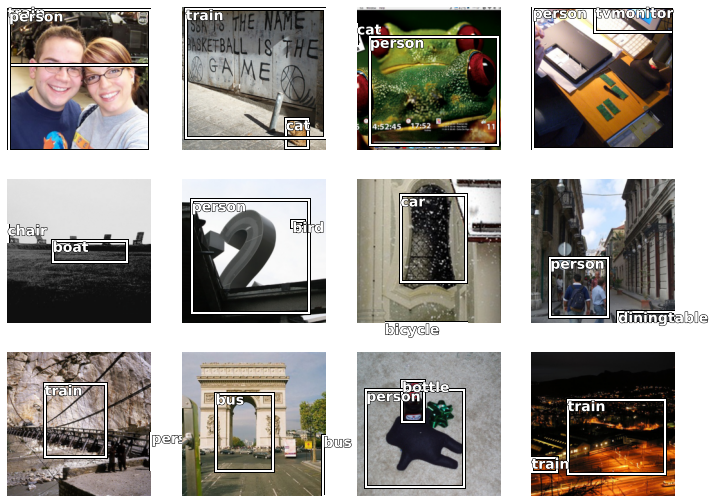

In [144]:
plot_top_losses(interp, 12)

# Multiple bounding boxes

https://github.com/fastai/fastai/blob/master/courses/dl2/pascal-multi.ipynb

https://github.com/cedrickchee/knowledge/blob/master/courses/fast.ai/deep-learning-part-2/2018-edition/lesson-9-multi-object-detection.md

### Data

In [22]:
img_names[1]

'000017.jpg'

In [23]:
getters[0](img_names[1]), getters[1](img_names[1]), getters[2](img_names[1])

(Path('/storage/data/pascal_2007/train/000017.jpg'),
 [[184, 61, 279, 199], [89, 77, 403, 336]],
 ['person', 'horse'])

In [24]:
multibboxdb = DataBlock(blocks=(ImageBlock, BBoxBlock,BBoxLblBlock),
                 get_items=get_img_names, 
                 get_x = getters[0], n_inp=1,
                 get_y = [getters[1],getters[2]],
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 splitter=RandomSplitter())

In [64]:
multibboxdls = multibboxdb.dataloaders(path)

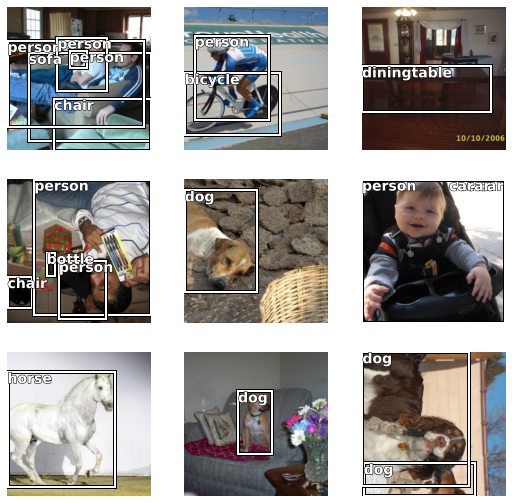

In [149]:
multibboxdls.show_batch()

In [150]:
x,y1,y2 = multibboxdls.one_batch()

In [156]:
y1[5], y2[5]

(tensor([[-0.9360, -0.5147,  0.7760,  0.4400],
         [-1.0000, -0.4560, -0.6693,  0.2320],
         [-0.0347, -0.5520,  0.0773, -0.4560],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0'),
 tensor([ 7,  7, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        device='cuda:0'))

### Matching problem - Anchor boxes

torch.Size([3, 281, 500])


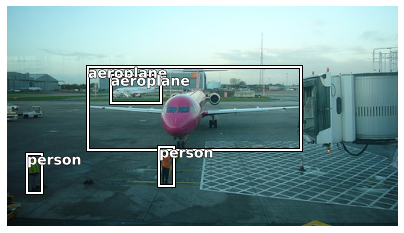

In [243]:
show_image_labels(4)

In [26]:
anchors_grid = 4
k = 1

anchors_offset = 1/(anchors_grid*2)
anchors_x = np.repeat(np.linspace(anchors_offset, 1-anchors_offset, anchors_grid), anchors_grid)
anchors_y = np.tile(np.linspace(anchors_offset, 1-anchors_offset, anchors_grid), anchors_grid)
anchors_centers = np.tile(np.stack([anchors_x,anchors_y], axis=1), (k,1))

anchors_sizes = np.array([[1/anchors_grid,1/anchors_grid] for i in range(anchors_grid*anchors_grid)])
anchors = tensor(np.concatenate([anchors_centers, anchors_sizes], axis=1)).float()

(0.0, 1.0)

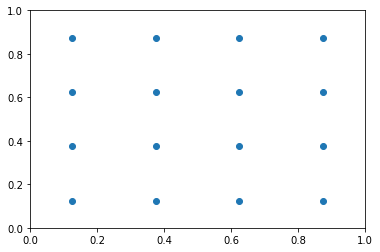

In [27]:
plt.scatter(anchors_x, anchors_y)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [28]:
anchors_centers

array([[0.125, 0.125],
       [0.125, 0.375],
       [0.125, 0.625],
       [0.125, 0.875],
       [0.375, 0.125],
       [0.375, 0.375],
       [0.375, 0.625],
       [0.375, 0.875],
       [0.625, 0.125],
       [0.625, 0.375],
       [0.625, 0.625],
       [0.625, 0.875],
       [0.875, 0.125],
       [0.875, 0.375],
       [0.875, 0.625],
       [0.875, 0.875]])

In [29]:
# Center , height_width
anchors

tensor([[0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.8750, 0.2500, 0.2500],
        [0.3750, 0.1250, 0.2500, 0.2500],
        [0.3750, 0.3750, 0.2500, 0.2500],
        [0.3750, 0.6250, 0.2500, 0.2500],
        [0.3750, 0.8750, 0.2500, 0.2500],
        [0.6250, 0.1250, 0.2500, 0.2500],
        [0.6250, 0.3750, 0.2500, 0.2500],
        [0.6250, 0.6250, 0.2500, 0.2500],
        [0.6250, 0.8750, 0.2500, 0.2500],
        [0.8750, 0.1250, 0.2500, 0.2500],
        [0.8750, 0.3750, 0.2500, 0.2500],
        [0.8750, 0.6250, 0.2500, 0.2500],
        [0.8750, 0.8750, 0.2500, 0.2500]])

In [30]:
def anchors_boxes_from_centers(ctr, hw): 
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [31]:
anchor_boxes = anchors_boxes_from_centers(anchors[:,:2], anchors[:,2:])
anchor_boxes

tensor([[0.0000, 0.0000, 0.2500, 0.2500],
        [0.0000, 0.2500, 0.2500, 0.5000],
        [0.0000, 0.5000, 0.2500, 0.7500],
        [0.0000, 0.7500, 0.2500, 1.0000],
        [0.2500, 0.0000, 0.5000, 0.2500],
        [0.2500, 0.2500, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.5000, 0.7500],
        [0.2500, 0.7500, 0.5000, 1.0000],
        [0.5000, 0.0000, 0.7500, 0.2500],
        [0.5000, 0.2500, 0.7500, 0.5000],
        [0.5000, 0.5000, 0.7500, 0.7500],
        [0.5000, 0.7500, 0.7500, 1.0000],
        [0.7500, 0.0000, 1.0000, 0.2500],
        [0.7500, 0.2500, 1.0000, 0.5000],
        [0.7500, 0.5000, 1.0000, 0.7500],
        [0.7500, 0.7500, 1.0000, 1.0000]])

In [32]:
anchor_labels = list(range(anchors_grid*anchors_grid))

**Visualize anchors**

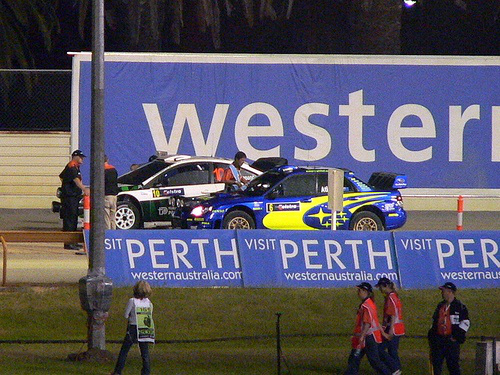

In [66]:
multibboxdls.dataset[69][0]

In [67]:
item = multibboxdls.dataset[69]
item[1]

TensorBBox([[347., 281., 384., 372.],
        [375., 279., 406., 375.],
        [111., 279., 157., 374.],
        [423., 286., 471., 372.],
        [219., 152., 252., 193.],
        [ 58., 145.,  83., 251.],
        [166., 158., 418., 245.],
        [ 66., 148., 274., 231.]])

In [68]:
encoded_item = multibboxdls.after_item(item)
encoded_target_boxes = encoded_item[1]
encoded_target_boxes

TensorBBox([[ 0.2960,  0.4987,  0.4933,  0.9840],
        [ 0.4453,  0.4880,  0.6107,  1.0000],
        [-0.9627,  0.4880, -0.7173,  0.9947],
        [ 0.7013,  0.5253,  0.9573,  0.9840],
        [-0.3867, -0.1893, -0.2107,  0.0293],
        [-1.2453, -0.2267, -1.1120,  0.3387],
        [-0.6693, -0.1573,  0.6747,  0.3067],
        [-1.2027, -0.2107, -0.0933,  0.2320]])

In [69]:
encoded_anchor_boxes = TensorBBox(array(anchor_boxes*2 - 1))
encoded_anchor_labels = TensorMultiCategory(anchor_labels)
encoded_anchor_boxes,encoded_anchor_labels

(TensorBBox([[-1.0000, -1.0000, -0.5000, -0.5000],
         [-1.0000, -0.5000, -0.5000,  0.0000],
         [-1.0000,  0.0000, -0.5000,  0.5000],
         [-1.0000,  0.5000, -0.5000,  1.0000],
         [-0.5000, -1.0000,  0.0000, -0.5000],
         [-0.5000, -0.5000,  0.0000,  0.0000],
         [-0.5000,  0.0000,  0.0000,  0.5000],
         [-0.5000,  0.5000,  0.0000,  1.0000],
         [ 0.0000, -1.0000,  0.5000, -0.5000],
         [ 0.0000, -0.5000,  0.5000,  0.0000],
         [ 0.0000,  0.0000,  0.5000,  0.5000],
         [ 0.0000,  0.5000,  0.5000,  1.0000],
         [ 0.5000, -1.0000,  1.0000, -0.5000],
         [ 0.5000, -0.5000,  1.0000,  0.0000],
         [ 0.5000,  0.0000,  1.0000,  0.5000],
         [ 0.5000,  0.5000,  1.0000,  1.0000]]),
 TensorMultiCategory([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]))

In [102]:
def show_image_anchors(dls, idx, ctx=None, display_shape=True):   
    item = dls.dataset[idx]
    encoded_item = dls.after_item(item)
    encoded_anchor_boxes = TensorBBox(array(anchor_boxes*2 - 1))
    encoded_anchor_labels = TensorMultiCategory(anchor_labels, vocab=map(str,anchor_labels))
    d_img, _, d_bboxlabels = dls.after_item.decode(encoded_item)
    _, _, d_anchorlabels = dls.after_item.decode((encoded_item[0],encoded_anchor_boxes,encoded_anchor_labels))
    for i,lbl in enumerate(d_bboxlabels[1]):
        d_bboxlabels[1][i] = d_bboxlabels[1][i] + f"({i})"
    d_anchorlabels[1] = list(map(str, anchor_labels))
    ctx = d_img.show(figsize=(7,7), ctx=ctx)
    ctx = d_anchorlabels.show(figsize=(7,7), ctx=ctx)
    d_bboxlabels.show(ctx=ctx);

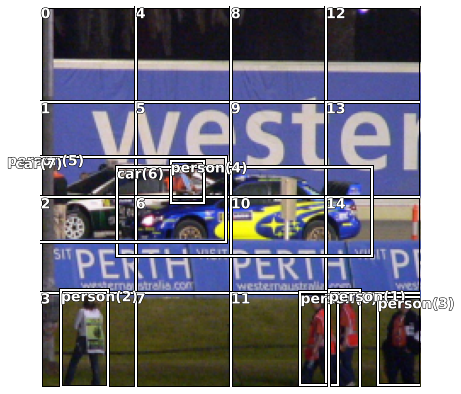

In [103]:
show_image_anchors(multibboxdls, 69)

### Matching problem - Intersection over Union

In [73]:
nb_anchors = encoded_anchor_boxes.shape[0]
nb_objects = encoded_target_boxes.shape[0]
nb_anchors,nb_objects

(16, 8)

Goal : compute a table of 16 x 8 overlaps between ground truth objects and anchor boxes
- rows = anchors
- columns = ground truth object
- cell = overlap between anchor and ground truth object

Max over row = object with max overlap for a given anchor
- if overlap < background_threshold => anchor = background
- if overlap > match_threshold      => anchor = object with max overlap

Definition of "overlap" : IoU = area of intersection / area of union

**Compute IoU**

Let's simulate broadcasting :

In [74]:
encoded_anchor_boxes.shape

torch.Size([16, 4])

In [75]:
encoded_anchor_boxes.unsqueeze(1).shape

torch.Size([16, 1, 4])

In [76]:
bc_anchor_boxes = encoded_anchor_boxes.unsqueeze(1).expand(nb_anchors,nb_objects,4)
bc_anchor_boxes.shape

torch.Size([16, 8, 4])

In [77]:
encoded_target_boxes.shape

torch.Size([8, 4])

In [78]:
encoded_target_boxes.unsqueeze(0).shape

torch.Size([1, 8, 4])

In [79]:
bc_target_boxes = encoded_target_boxes.unsqueeze(0).expand(nb_anchors,nb_objects,4)
bc_target_boxes.shape

torch.Size([16, 8, 4])

In [80]:
top_left_intersect = torch.max(bc_anchor_boxes[...,:2], bc_target_boxes[...,:2])
bottom_right_intersect = torch.min(bc_anchor_boxes[...,2:], bc_target_boxes[...,2:])
height_width_intersect = torch.clamp(bottom_right_intersect - top_left_intersect, min=0) 
areas_intersect = height_width_intersect[...,0] * height_width_intersect[...,1]
areas_intersect

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0266, 0.1053],
        [0.0000, 0.0000, 0.0029, 0.0000, 0.0000, 0.0000, 0.0519, 0.1160],
        [0.0000, 0.0000, 0.1214, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0333, 0.0000, 0.0787, 0.0857],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0052, 0.0000, 0.1533, 0.0943],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0787, 0.0000],
        [0.0003, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.1533, 0.0000],
        [0.0955, 0.0273, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.000

In [81]:
def intersection(anchor_boxes, target_boxes):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    nb_anchors = anchor_boxes.shape[0]
    nb_objects = target_boxes.shape[0]
    bc_anchor_boxes = encoded_anchor_boxes.unsqueeze(1).expand(nb_anchors,nb_objects,4)
    bc_target_boxes = encoded_target_boxes.unsqueeze(0).expand(nb_anchors,nb_objects,4)
    top_left_intersect = torch.max(bc_anchor_boxes[...,:2], bc_target_boxes[...,:2])
    bottom_right_intersect = torch.min(bc_anchor_boxes[...,2:], bc_target_boxes[...,2:])
    height_width_intersect = torch.clamp(bottom_right_intersect - top_left_intersect, min=0) 
    areas_intersect = height_width_intersect[...,0] * height_width_intersect[...,1]
    return areas_intersect

In [83]:
areas_intersect = intersection(encoded_anchor_boxes, encoded_target_boxes)
areas_intersect

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0266, 0.1053],
        [0.0000, 0.0000, 0.0029, 0.0000, 0.0000, 0.0000, 0.0519, 0.1160],
        [0.0000, 0.0000, 0.1214, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0333, 0.0000, 0.0787, 0.0857],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0052, 0.0000, 0.1533, 0.0943],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0787, 0.0000],
        [0.0003, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.1533, 0.0000],
        [0.0955, 0.0273, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.000

In [85]:
anchors_areas = (encoded_anchor_boxes[...,2]-encoded_anchor_boxes[...,0])*(encoded_anchor_boxes[...,3]-encoded_anchor_boxes[...,1])
anchors_areas

tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500])

In [86]:
targets_areas = (encoded_target_boxes[...,2]-encoded_target_boxes[...,0])*(encoded_target_boxes[...,3]-encoded_target_boxes[...,1])
targets_areas

tensor([0.0958, 0.0847, 0.1243, 0.1174, 0.0385, 0.0754, 0.6236, 0.4911])

In [87]:
sum_areas = anchors_areas.unsqueeze(1) + targets_areas.unsqueeze(0)
sum_areas

tensor([[0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.367

In [88]:
areas_union = sum_areas - areas_intersect
areas_union

tensor([[0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8470, 0.6357],
        [0.3458, 0.3347, 0.3714, 0.3674, 0.2885, 0.3254, 0.8217, 0.6251],
        [0.3458, 0.3347, 0.2529, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2552, 0.3254, 0.7949, 0.6554],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2833, 0.3254, 0.7203, 0.6467],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.7949, 0.7411],
        [0.3455, 0.3340, 0.3743, 0.3674, 0.2885, 0.3254, 0.7203, 0.7411],
        [0.2503, 0.3073, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.367

In [90]:
def union(anchor_boxes, target_boxes, areas_intersect):
    "Compute the IoU values of `anchors` by `targets`."
    anchors_areas = (anchor_boxes[...,2]-anchor_boxes[...,0])*(anchor_boxes[...,3]-anchor_boxes[...,1])
    targets_areas = (target_boxes[...,2]-target_boxes[...,0])*(target_boxes[...,3]-target_boxes[...,1])
    sum_areas = anchors_areas.unsqueeze(1) + targets_areas.unsqueeze(0)
    areas_union = sum_areas - areas_intersect
    return areas_union

In [92]:
areas_union = union(encoded_anchor_boxes, encoded_target_boxes, areas_intersect)
areas_union

tensor([[0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8470, 0.6357],
        [0.3458, 0.3347, 0.3714, 0.3674, 0.2885, 0.3254, 0.8217, 0.6251],
        [0.3458, 0.3347, 0.2529, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2552, 0.3254, 0.7949, 0.6554],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2833, 0.3254, 0.7203, 0.6467],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.7949, 0.7411],
        [0.3455, 0.3340, 0.3743, 0.3674, 0.2885, 0.3254, 0.7203, 0.7411],
        [0.2503, 0.3073, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.3674, 0.2885, 0.3254, 0.8736, 0.7411],
        [0.3458, 0.3347, 0.3743, 0.367

In [94]:
def IoU(anchor_boxes, target_boxes):
    "Compute the IoU values of `anchors` by `targets`."
    areas_intersect = intersection(anchor_boxes, target_boxes)
    areas_union = union(anchor_boxes, target_boxes, areas_intersect)
    return areas_intersect/(areas_union+1e-8)

In [98]:
iou_table = IoU(encoded_anchor_boxes, encoded_target_boxes)
iou_table,item[2]

(tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0315, 0.1657],
         [0.0000, 0.0000, 0.0079, 0.0000, 0.0000, 0.0000, 0.0632, 0.1856],
         [0.0000, 0.0000, 0.4798, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.1306, 0.0000, 0.0990, 0.1307],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0182, 0.0000, 0.2129, 0.1459],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0990, 0.0000],
         [0.0008, 0.0020, 0.0000, 0.0000, 0.0000, 0.0000, 0.2129, 0.0000],
         [0.3816, 0.0889, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000,

In [105]:
matches = encoded_anchor_boxes.new(nb_anchors).zero_().long() - 2
matches

TensorBBox([-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2])

In [99]:
vals,idxs = torch.max(iou_table,1)
vals,idxs

(tensor([0.0000, 0.1657, 0.1856, 0.4798, 0.0000, 0.1307, 0.2129, 0.0000, 0.0000,
         0.0990, 0.2129, 0.3816, 0.0000, 0.0325, 0.0653, 0.4697]),
 tensor([7, 7, 7, 2, 7, 7, 6, 7, 7, 6, 6, 0, 7, 6, 6, 3]))

In [108]:
bkg_thr=0.1
matches[vals < bkg_thr] = -1
match_thr=0.2
matches[vals > match_thr] = idxs[vals > match_thr]
matches

TensorBBox([-1, -1, -1,  2, -1, -1,  6, -1, -1, -1,  6,  0, -1, -1, -1,  3])

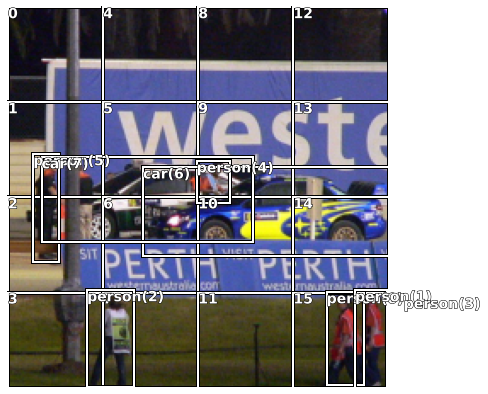

In [109]:
show_image_anchors(multibboxdls, 69)

In [ ]:
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    ious = IoU_values(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    return matches

### Model

In [244]:
resnet_body = learn2.model[0]
resnet_body.summary(x)

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
_________________________________________________

=> 16 bounding boxes

In [245]:
ConvLayer?

In [246]:
class SSDHead(nn.Module):
    def __init__(self, k, classes):
        super().__init__()
        # Stride 1 conv doesn't change the dimension size, but we have a mini neural network
        self.conv1 = ConvLayer(512, 256, stride=1) # 7x7 grid of 256 features
        # Stride 2 conv 
        self.conv2 = ConvLayer(256, 256, stride=2) # 4x4 grid of 256 features
        # Classification and bounding boxes regression
        self.bbox_conv = nn.Conv2d(256, 4 * k, 3, stride=1, padding=1)
        self.bbox_range = SigmoidRange(-1,1)        
        self.label_conv = nn.Conv2d(256, (classes + 1) * k, 3, stride=1, padding=1) # +1 for background
        
    def forward(self, x):
        x = F.relu(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return [self.bbox_range(self.bbox_conv(x)),self.label_conv(x)]

In [247]:
multibboxmodel = create_cnn_model(resnet34, n_out=None, pretrained=True, custom_head=SSDHead(1,20))

In [248]:
multibboxmodel.to(multibboxdls.device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [249]:
bbox_activations,label_activations = multibboxmodel(x)

In [250]:
bbox_activations.shape, label_activations.shape

(torch.Size([64, 4, 4, 4]), torch.Size([64, 21, 4, 4]))

In [251]:
def flatten_grid_cells(activations, k):
    bs, nf, gx, gy = activations.shape
    activations = activations.permute(0, 2, 3, 1).contiguous()
    return activations.view(bs, -1, nf//k)

In [252]:
bbox_activations = flatten_grid_cells(bbox_activations,1)
label_activations = flatten_grid_cells(label_activations,1)

In [253]:
bbox_activations.shape, label_activations.shape

(torch.Size([64, 16, 4]), torch.Size([64, 16, 21]))

### To be continued ...

## The Model

The architecture we are going to use is called `RetinaNet`. I've exported this all myself for you guys to use quickly, if you want to explore what's going on in the code I'd recommend the Object Detection lesson [here](https://www.youtube.com/watch?v=Z0ssNAbe81M&t=4496s)

In [25]:
from fastai2.vision.models.unet import _get_sz_change_idxs, hook_outputs

def conv2d(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias=False, init=nn.init.kaiming_normal_):
    "Create and initialize `nn.Conv2d` layer."
    if padding is None: padding = ks // 2
    return init_default(nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias), init)

class LateralUpsampleMerge(nn.Module):
    "Merge the features coming from the downsample path (in `hook`) with the upsample path."
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)
    
    def forward(self, x):
        return self.conv_lat(self.hook.stored) + F.interpolate(x, self.hook.stored.shape[-2:], mode='nearest')

class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"
    def __init__(self, encoder:nn.Module, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sz_change_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        self.encoder = encoder
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)
        self.p6top7 = nn.Sequential(nn.ReLU(), conv2d(chs, chs, stride=2, bias=True))
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, sfs_szs[idx][1], hook) 
                                     for idx,hook in zip(sfs_idxs[-2:-4:-1], self.sfs[-2:-4:-1])])
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs)
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs)
        
    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        "Helper function to create one of the subnet for regression/classification."
        layers = [ConvLayer(chs, chs, bias=True, norm_type=None) for _ in range(n_conv)]
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        layers[-1].bias.data.zero_().add_(final_bias)
        layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)
    
    def _apply_transpose(self, func, p_states, n_classes):
        #Final result of the classifier/regressor is bs * (k * n_anchors) * h * w
        #We make it bs * h * w * n_anchors * k then flatten in bs * -1 * k so we can contenate
        #all the results in bs * anchors * k (the non flatten version is there for debugging only)
        if not self.flatten: 
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0,2,3,1).view(*sz,-1,n_classes) for p,sz in zip(p_states,sizes)]
        else:
            return torch.cat([func(p).permute(0,2,3,1).contiguous().view(p.size(0),-1,n_classes) for p in p_states],1)
    
    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5top5(c5.clone()), self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[-1]))
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        return [self._apply_transpose(self.classifier, p_states, self.n_classes), 
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]
    
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

We're still going to use transfer learning here by creating an `encoder` (body) of our model and a head

In [26]:
encoder = create_body(resnet34, pretrained=True)

Now that we have our encoder, we can call the `RetinaNet` architecture. We'll pass in the encoder, the number of classes, and what we want our final bias to be on the last convolutional layer (how we initialize our model). Jeremy has his example at -4 so let's use this

In [28]:
get_c(multibboxdls)

4

In [19]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

Another big difference is the head of our model. Instead of our linear layers with pooling layers:

In [20]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=124, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

We have one with a smoother, a classifer, and a `box_regressor` (to get our points)

In [21]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [22]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [23]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## Loss Function
Now we can move onto our loss function.

In [24]:
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

def encode_class(idxs, n_classes):
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else torch.tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else torch.tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    ious = IoU_values(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    return matches

def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

def IoU_values(anchs, targs):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchs, targs)
    anc_sz, tgt_sz = anchs[:,2] * anchs[:,3], targs[:,2] * targs[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

class RetinaNetFocalLoss(nn.Module):
    def __init__(self, gamma:float=2., alpha:float=0.25,  pad_idx:int=0, scales=None, ratios=None, reg_loss=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes) -> bool:
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes, device:torch.device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx
    
    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred.detach())
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else: bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt)/torch.clamp(bbox_mask.sum(), min=1.)
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

class SigmaL1SmoothLoss(nn.Module):
    def forward(self, pred, targ):
        reg_diff = torch.abs(targ - pred)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()

For RetinaNet to work, we need to define what the aspect ratio's and scales of our image should be. The paper used [1,2^(1/3), 2^(2/3)], but they also used an image size of 600 pixels, so even the largest feature map (box) gave anchors that covered less than the image. But for us it would go over. As such we will use -1/3 and -2/3 instead. We will need these for inference later!

In [25]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

Let's make our loss function, which is `RetinaNetFocalLoss`

In [26]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

Now let's make our `Learner`!

We want to freeze our `encoder` and keep everything else unfrozen to start

In [27]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [28]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [29]:
learn.freeze()

In [30]:
learn.summary()

RetinaNet (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
__________________________________________________

We can see it was split and frozen by looking at the summary!

Now let's train!

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=0.00013182566908653826)

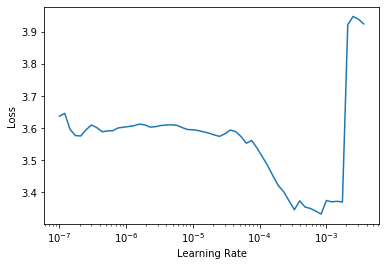

In [102]:
learn.lr_find()

In [103]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [151]:
learn.save("objdetect1")

## Inference

In [31]:
learn.load("objdetect1")

In [50]:
xs = dls.valid.one_batch()[0]

In [51]:
output = learn.model(xs)

In [52]:
len(output),type(output[0]),type(output[1]),type(output[2])

(3, torch.Tensor, torch.Tensor, list)

In [53]:
output[0].shape

torch.Size([64, 35901, 20])

In [54]:
output[1].shape

torch.Size([64, 35901, 4])

In [55]:
output[2]

[[28, 28], [56, 56], [7, 7], [4, 4], [2, 2]]

In [62]:
from matplotlib import patches, patheffects

def _draw_outline(o, lw:int):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax:plt.Axes, b, color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

def nms(boxes, scores, thresh=0.5):
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort], scores[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        #pdb.set_trace()
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals <= thresh
        if len(mask_keep.nonzero()) == 0: break
        idx_first = mask_keep.nonzero().min().item()
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)

def process_output(output, i, scales, ratios, detect_thresh=0.25):
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

def show_preds(img, output, idx, scales, ratios, detect_thresh=0.25, classes=None):
    bbox_pred, scores, preds = process_output(output, idx, scales, ratios, detect_thresh)
    to_keep = nms(bbox_pred, scores)
    bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
    t_sz = torch.Tensor([*img.size])[None].float()
    bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
    bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
    bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
    bbox_pred = bbox_pred.long()
    _, ax = plt.subplots(1,1)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        img.show(ax=ax)
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

def get_predictions(output, idx, detect_thresh=0.05):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    to_keep = nms(bbox_pred, scores)
    return bbox_pred[to_keep], preds[to_keep], scores[to_keep]

In [69]:
test_idx = 1

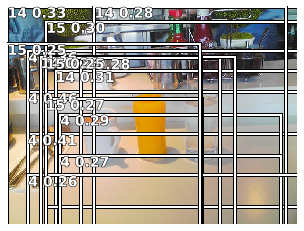

In [74]:
show_preds(dls.valid.dataset[test_idx][0],output,test_idx,scales,ratios)